In [1]:
%matplotlib inline

In [2]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation, UnknownSiteException

In [3]:
def primary_beam(primary_beam_extension: np.ndarray, l_0: float, m_0: float):
    gaussian = np.exp(-(l_0**2 + m_0**2)/(2*primary_beam_extension**2))
    return gaussian

In [4]:
def generate_point_sources(intensity, spectral_index, spectral_curvature, l_0, m_0, uvw, freq, freq_0, primary_beam):
    # Primary beam is not yet implemented
    n_0 = np.sqrt(1-l_0**2-m_0**2)
    intensity_freq = primary_beam * intensity/n_0 * (freq/freq_0)**(spectral_index + spectral_curvature * np.log10(freq/freq_0))
    fourier_transform = np.exp(2 * np.pi * 1j * (l_0 * uvw[0,:] + m_0 * uvw[1,:] + (n_0 - 1) * uvw[2,:]))
    visibilities = intensity_freq[np.newaxis,:,np.newaxis] * fourier_transform
    return visibilities

In [5]:
def weighting_scheme(weights, uv_pix_1d, N, scheme="natural", robust_param=2.):
    weights_bincount = np.bincount(uv_pix_1d, weights, minlength=N*N)
    weights_w_1d = weights_bincount[uv_pix_1d]
    
    if scheme.lower() == "natural":
        return weights
    elif scheme.lower() == "uniform":
        return weights/weights_w_1d
    elif scheme.lower() == "robust":
        f_squared_num = (5.* np.power(10, -robust_param))**2
        f_squared_den = np.sum(weights_w_1d**2)/np.sum(weights)
        f_squared = f_squared_num/f_squared_den
        return weights/(1.+(weights_w_1d*f_squared))
    else:
        raise ValueError("Not known scheme")

In [6]:
def complex_bincount(weights, x, minlength: int = None):
    real_w = weights.real
    imag_w = weights.imag
    return np.bincount(x, real_w,
                       minlength=minlength) + 1j * np.bincount(x, imag_w, minlength=minlength)

In [7]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec) * np.ones_like(H)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec) * np.ones_like(H)]])

    return R

In [8]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [9]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [10]:
def local_enu_to_earth_location(e, n, u, reference_location):
    down = -u
    cart = CartesianRepresentation(n, e, down)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [11]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return enu_coords

In [12]:
def enu_to_local_altaz(enu_baselines, distance):
    azimuth = np.arctan2(enu_baselines[0], enu_baselines[1])
    elevation = np.arcsin(enu_baselines[2]/distance) 
    return azimuth, elevation

In [13]:
def read_txt_file(filename):
    # Read data
    dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]
    data = np.loadtxt(antenna_config_file, dtype=dtype)
    # Read header
    header = []
    with open(antenna_config_file) as input_file:
        # Read only the first two lines
        for _ in range(2):
            li=next(input_file).strip()
            if li.startswith("#"):
                header.append(list(map(str.strip, li.strip().replace("#", "").strip().split("="))))
    header=dict(header)
    return header, data
    

In [14]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [15]:
antenna_config_path = "antenna_configs/"

In [16]:
antenna_config_file = antenna_config_path + "alma.cycle10.9.cfg"

In [17]:
# Reading the data
header, data = read_txt_file(antenna_config_file)

In [18]:
# We assign XYZ, diameters and antenna names
diameters = data["D"]
antenna_names = data["id"]

In [19]:
# We calculate the center of array (COA) using Astropy Earth Location
try:
    telescope_center = EarthLocation.of_site(header["observatory"].lower())
except UnknownSiteException:
    #If location if not found and position are in ITRF coordinates, we use the first antenna as the center of array
    if header["coordsys"] == "XYZ":
        telescope_center = EarthLocation.from_geocentric(data["x"][0], data["y"][0], data["z"][0], u.m)
    else:
        raise ValueError("Telescope center not found")

In [20]:
# Depending on the coordinate system, we will need to convert to ENU if necessary
if header["coordsys"] == "XYZ": # ITRF, ECEF
    local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)
    enu_coords = np.array(earth_location_to_local_enu(local_xyz, telescope_center))
else:
    enu_coords = np.vstack([data["x"], data["y"], data["z"]])

In [21]:
antenna_ids = np.arange(0, enu_coords.shape[1])
n_antennas = len(antenna_ids)
print(n_antennas)

43


In [22]:
# Calculate combinations of pairs of antennas in ENU coordinates
b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1], dtype=bool)]
# We discard the diagonal which has no pairs
# b_enu = b_enu[:, np.tri(b_enu.shape[-1], k=1, dtype=bool)]

In [23]:
# We calculate the distance between different pairs of antennas
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
baselines_distance_2d = np.sqrt(np.sum(b_enu[0:2]**2, axis=0))
max_baseline = np.max(baselines_distance_2d)
idx_nearest_zero = np.argmin(np.sqrt(np.sum(enu_coords[0:2]**2, axis=0)))
antenna_nearest_zero = enu_coords[:, idx_nearest_zero]
farthest_antenna = np.max(np.sqrt(np.sum((enu_coords[0:2] - antenna_nearest_zero[0:2, np.newaxis])**2, axis=0)))

In [24]:
print(max_baseline/1000)

13.8946162109375


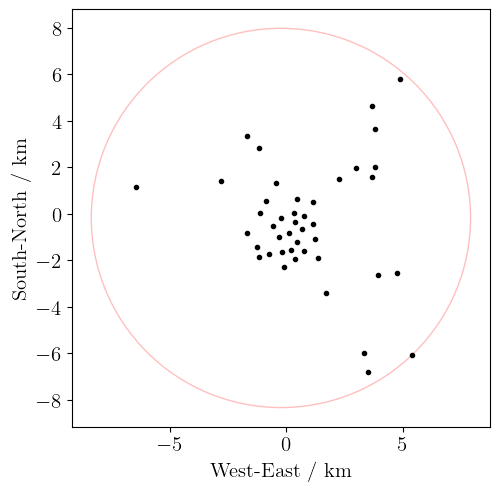

In [25]:
fig, ax = plt.subplots(layout='constrained')

dish_circle = plt.Circle((antenna_nearest_zero[0]/1000, antenna_nearest_zero[1]/1000), farthest_antenna/1000, facecolor="white", edgecolor='r', alpha=0.25)
ax.plot(enu_coords[0]/1000, enu_coords[1]/1000, '.k')
ax.add_patch(dish_circle)
ax.set(
        aspect=1,
        xlabel='West-East / km',
        ylabel='South-North / km'
)

#ax.legend(["Antennas", "Dish of {0:0.1f} km".format(max_baseline/1000)], loc="upper right", bbox_to_anchor=(2., 1.03), fancybox=True)
#ax.set_aspect('equal')
fig.savefig("antennas_diameter_ska197.pdf", dpi=300)

In [26]:
# We convert coordinates from ENU to ALT-AZ
azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

In [27]:
# We get the latitude of the COA in radians
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [28]:
# We convert baselines coordinates from ALT-AZ to Equatorial
x_equatorial = np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth)
y_equatorial = np.cos(elevation) * np.sin(azimuth)
z_equatorial = np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth)

In [29]:
xyz_equatorial =  abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [30]:
# We set the observed Hour Angle and the declination
HA = np.arange(-2, 2, 0.1) * np.pi / 12.
#HA = 0.0
dec = np.radians(-23.0000006847)

In [31]:
# We calculate the rotation matrix
R_matrix = calc_R(HA, dec)

In [32]:
# Rotation matrix has shape of (3,3, HA) and XYZ has shape of (3, nBaselines)
# Therefore to implement matrix multiplication (row * col) we need to broadcast and multiply and then sum the colums (axis=1)
uvw_meters = np.sum(R_matrix[...,np.newaxis] * xyz_equatorial[np.newaxis,:,np.newaxis,:], axis=1)

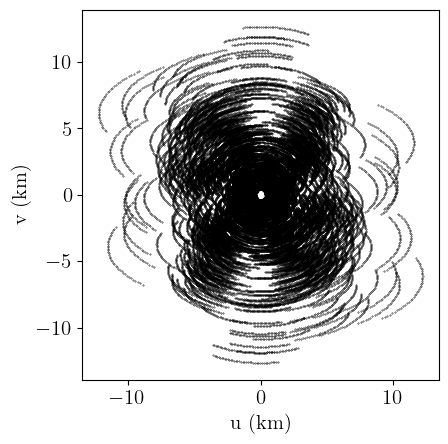

In [33]:
fig, ax = plt.subplots()
ax.scatter(uvw_meters[0]/1000,uvw_meters[1]/1000, c="black", marker=".", s=0.4)
ax.set_xlabel('u (km)') 
ax.set_ylabel('v (km)')
ax.set_aspect('equal')
fig.savefig("snapshot.pdf", dpi=300, bbox_inches='tight')

In [34]:
# We can also set a linearly spaced frequency range in order to increase the uv-coverage
freq_range = np.linspace(211e9, 275e9, 50)
lambda_meters = c.value / freq_range

In [35]:
# We use broadcasting in order to divide uvw coordinates in meters by an array of wavelengths
uvw_lambdas = uvw_meters[:,:, np.newaxis, :] / lambda_meters[np.newaxis, np.newaxis, :, np.newaxis]

In [36]:
uvw_lambdas.shape

(3, 40, 50, 1806)

In [37]:
#import matplotlib.animation

#plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  
#plt.ioff()
#fig, ax = plt.subplots()

#def animate(t):
#    plt.cla()
#    plt.scatter(uvw_lambdas[0,:, 0:t, :]/1e3, uvw_lambdas[1, :, 0:t, :]/1e3, c="black", marker=".", s=0.4)
#    plt.xlabel(r'u (k$\lambda$)') 
#    plt.ylabel(r'v (k$\lambda$)')
#    plt.gca().set_aspect('equal')

#anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(freq_range), interval=250)
#anim

In [38]:
#writervideo = matplotlib.animation.FFMpegWriter(fps=30) 
#anim.save("ska_freq.mp4", writer=writervideo)

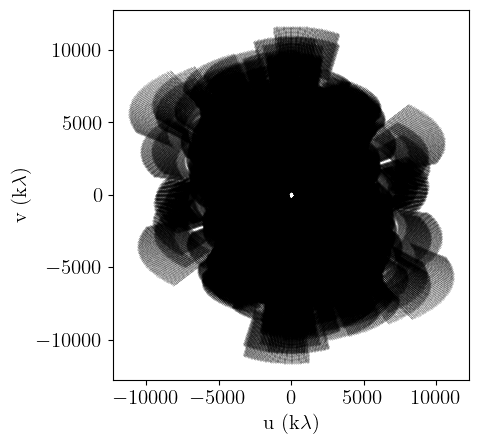

In [39]:
fig, ax = plt.subplots()
ax.scatter(uvw_lambdas[0]/1e3,uvw_lambdas[1]/1e3, c="black", marker=".", s=0.2, alpha=0.5, rasterized=True)
ax.set_xlabel(r'u (k$\lambda$)') 
ax.set_ylabel(r'v (k$\lambda$)')
ax.set_aspect('equal')
fig.savefig("uvplane.pdf", dpi=100, bbox_inches='tight')

In [40]:
from astropy.io import fits
from astropy.wcs import WCS
import cmcrameri.cm as cmc

hdul = fits.open("test_images/ppdisk672_GHz_50pc.fits")
header = hdul[0].header
data = hdul[0].data.squeeze()

In [41]:
ft_data = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data)))

In [42]:
wcs = WCS(header, naxis=2)

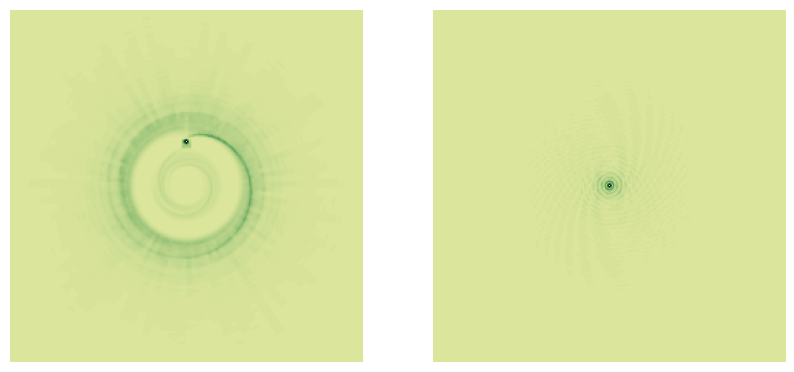

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(data, origin="lower", cmap=cmc.tofino_r)
ax[1].imshow(np.abs(ft_data), origin="lower", cmap=cmc.tofino_r)
ax[0].axis('off')
ax[1].axis('off')
fig.savefig("proto_disk.pdf", dpi=300, bbox_inches='tight')

In [44]:
dx = -np.deg2rad(header["CDELT1"])
dy = np.deg2rad(header["CDELT2"])
N = header["NAXIS1"]
du = 1 / (N*dx)
dv = 1 / (N*dy)

In [45]:
u_pix = (uvw_lambdas[0]/du + N//2 + 0.5).ravel().astype(np.int32)
v_pix = (uvw_lambdas[1]/dv + N//2 + 0.5).ravel().astype(np.int32)
weights = np.ones_like(u_pix, dtype=np.float32).ravel()

In [46]:
uv_pix_1d = N * v_pix + u_pix

In [47]:
weights_after_scheme = weighting_scheme(weights, uv_pix_1d, N, scheme="robust", robust_param=-2.0)

In [48]:
weights_1d = np.bincount(uv_pix_1d, weights_after_scheme, minlength=N*N)

In [49]:
weight_image = np.reshape(weights_1d, (N,N))

In [50]:
psf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(weight_image))).real * weight_image.size
dirty = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(weight_image*ft_data / np.sum(weight_image)))).real * weight_image.size

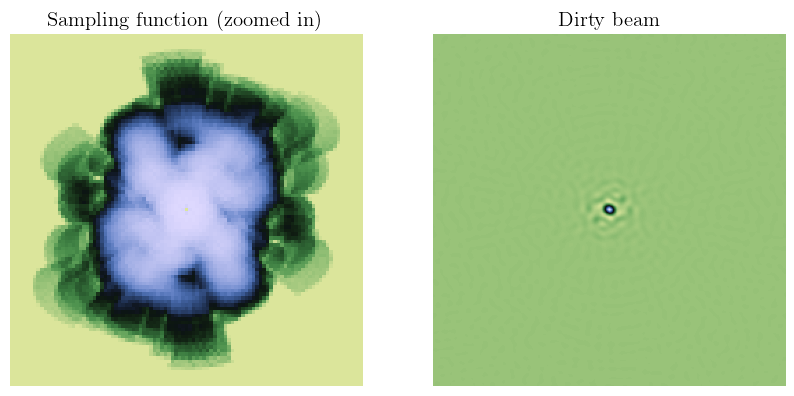

In [51]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.abs(weight_image), origin="lower", cmap=cmc.tofino_r)
ax[0].set_title("Sampling function (zoomed in)")
ax[1].imshow(psf, origin="lower", cmap=cmc.tofino_r)
ax[1].set_title("Dirty beam")
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_xlim([128-50, 128+50])
ax[0].set_ylim([128-50, 128+50])
fig.savefig("dirty_beam.pdf", dpi=300, bbox_inches='tight')

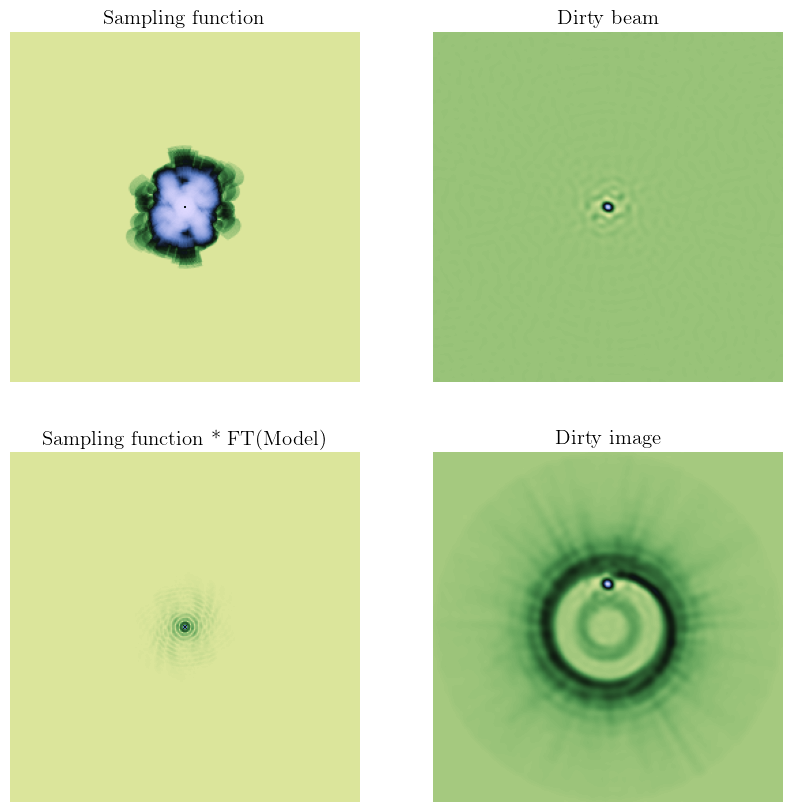

In [52]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(np.abs(weight_image), origin="lower", cmap=cmc.tofino_r)
ax[0,0].set_title("Sampling function")
ax[0,1].imshow(psf, origin="lower", cmap=cmc.tofino_r)
ax[0,1].set_title("Dirty beam")
ax[1,0].imshow(np.abs(weight_image*ft_data), origin="lower", cmap=cmc.tofino_r)
ax[1,0].set_title("Sampling function * FT(Model)")
ax[1,1].imshow(dirty, origin="lower", cmap=cmc.tofino_r)
ax[1,1].set_title("Dirty image")
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
fig.savefig("proto_transforms_robust.pdf", dpi=300, bbox_inches='tight')

In [53]:
dx

-1.5077706602660822e-08

In [54]:
# Primary beam has an extension of lambda/D
primary_beam_extension = lambda_meters/np.unique(diameters)
primary_beam_arg = primary_beam(primary_beam_extension, np.abs(dx)*60, 0.0)
vis = generate_point_sources(2.0, 3.0, -1.0, np.abs(dx)*60, 0.0, uvw_lambdas, freq_range, np.mean(freq_range), primary_beam_arg)

In [55]:
vis.shape, freq_range.shape, uvw_lambdas.shape, HA.shape, xyz_equatorial.shape

((40, 50, 1806), (50,), (3, 40, 50, 1806), (40,), (3, 1806))

In [56]:
vis_1d = complex_bincount(weights_after_scheme * vis.flatten(), uv_pix_1d, minlength=N*N)

In [57]:
vis_image = np.reshape(vis_1d, (N,N))
vis_image_aux = np.zeros_like(vis_image)
np.divide(vis_image, weight_image, out=vis_image_aux, where=weight_image > 0.0)

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

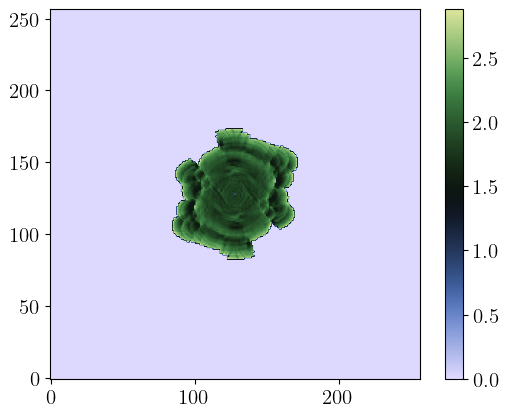

In [58]:
plt.imshow(np.abs(vis_image_aux), origin="lower", cmap=cmc.tofino)
plt.colorbar()

In [59]:
dirty = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(weight_image * vis_image_aux / np.sum(weight_image)))).real * vis_image.size

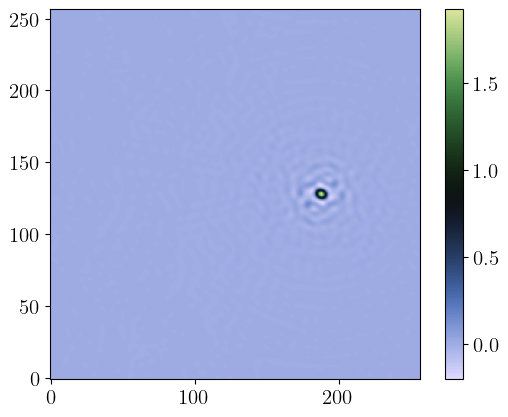

In [60]:
plt.imshow(dirty, origin="lower", cmap=cmc.tofino)
plt.colorbar()